#Check metrics for a specific dataset

## Installs

In [1]:
%%capture
!pip install rouge-score sacrebleu #sentencepiece

## Imports

In [2]:
import matplotlib.pyplot as plt
import nltk
import pandas as pd
import sacrebleu
#import sentencepiece as sp

from google.colab import files
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from rouge_score import rouge_scorer
from sacrebleu.metrics import BLEU, CHRF
from typing import List, Dict

In [18]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

##Load dataset

In [4]:
FILENAME = 'all_translations.tsv'

In [5]:
df = pd.read_csv(FILENAME, sep='\t')

## Create metrics

#### aux rounding func

In [6]:
def round_perc(num: float) -> float:
  return round(num*100, 2)

### Rouge

In [7]:
Rouge = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

In [8]:
def eval_rouge(translation, reference) - float:
  '''Takes average of uni- bi- and large- grams'''
  rouge_dict = {'rouge1':0,
                'rouge2':0,
                'rougeL':0
                }
  rouges = Rouge.score(reference, translation)
  for key in rouges.keys():
    rouge_dict[key] += rouges[key].fmeasure
  return round_perc(pd.Series(rouge_dict.values()).mean())

### BLEU

In [9]:
smoothing_zero_ngrams = SmoothingFunction()

In [10]:
def get_sent_bleu(sentence: str, reference: str) -> float:
  score = sentence_bleu([reference.split()], sentence.split(),
                        weights = (0.25, 0.5, 0.25), smoothing_function=smoothing_zero_ngrams.method1)
  return round_perc(score)


def get_bleu(sentence: str, reference: str) -> float:
  score = corpus_bleu([[reference.split()]], [sentence.split()],
                      smoothing_function=smoothing_zero_ngrams.method1)
  return round_perc(score)

def get_sacrebleu(sent_series, ref_series): #crutch
  #irrelevant scores
  for sent, ref in zip(sent_series, ref_series):
    return sacrebleu.corpus_bleu([sent], [[ref]])

def get_chrf(sentence, reference):
  chrf = CHRF()
  return round(chrf.corpus_score([sentence], [[reference]]).score, 2)


### meteor

In [11]:
def get_meteor(sentence: str, reference: str) -> float:
  score = meteor_score([reference.split()], sentence.split())
  return round_perc(score)

TER

In [35]:
def ter(hypothesis, reference) -> int:
    n = len(reference)
    m = len(hypothesis)

    dp = [[0] * (m + 1) for _ in range(n + 1)]

    for i in range(n + 1):
        dp[i][0] = i
    for j in range(m + 1):
        dp[0][j] = j

    for i in range(1, n + 1):
        for j in range(1, m + 1):
            cost = 0 if reference[i - 1] == hypothesis[j - 1] else 1
            dp[i][j] = min(dp[i - 1][j] + 1, dp[i][j - 1] + 1, dp[i - 1][j - 1] + cost)
    return dp[n][m]

###Metrics

In [13]:
METRICS = {'sent_bleu': get_sent_bleu,
          'bleu':  get_bleu,
          'rogue': eval_rouge,
          'meteor': get_meteor,
           'TER':ter,
           #'sacre bleu': get_sacrebleu,
           'CHRF++': get_chrf
          }

## Test functions

In [14]:
def apply_func(func: Callable, df: pd.DataFrame=df) -> pd.DataFrame:
  scores = pd.DataFrame(columns=df.columns[2:])
  for col in df.columns[2:]:
    scores[col] = df.apply(lambda row: func(row[col], row['en_expert']), axis=1)
  return scores

In [15]:
def test_metric(func: Callable, name: str, df: pd.DataFrame=df) -> None:
    result = apply_func(func, df)
    fig, ax = plt.subplots(figsize=(12,6))
    colors = result.plot.area(ax=ax, stacked=False, alpha=0.6).get_lines()

    for i, (col, mean_value) in enumerate(result.mean().items()):   #could also use median
        ax.axhline(y=mean_value, linestyle='--', color=colors[i].get_color(), label=f'Mean {col}: {mean_value:.2f}')

    ax.legend()
    plt.title(name)
    plt.show()

## Run the visualtization

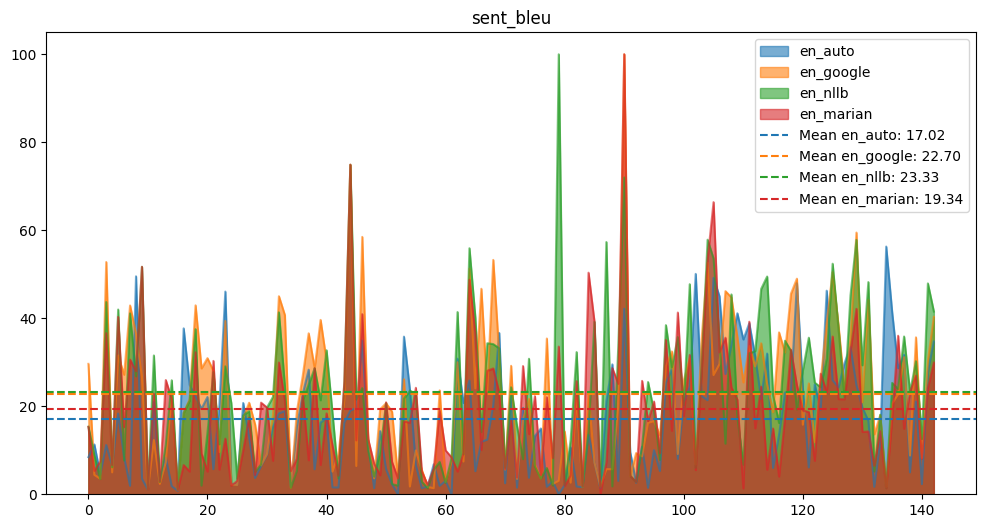

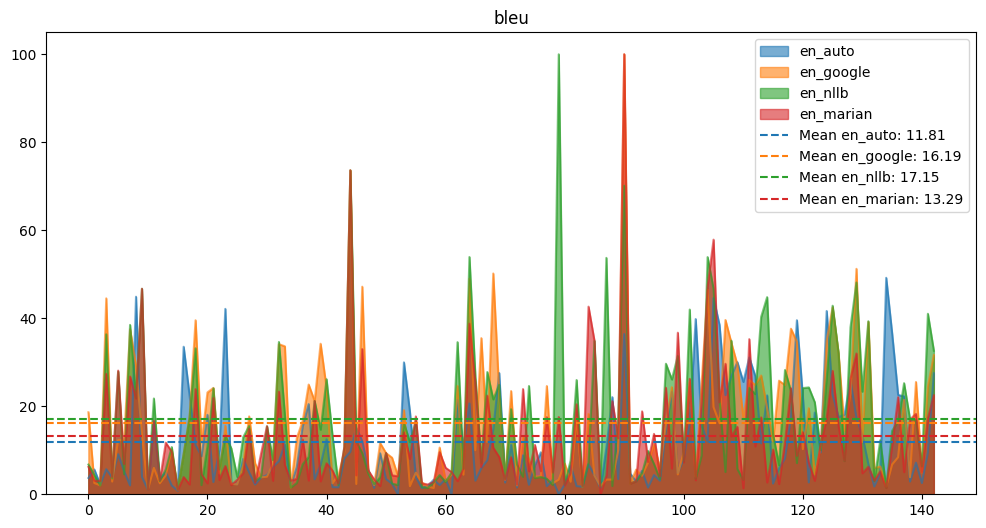

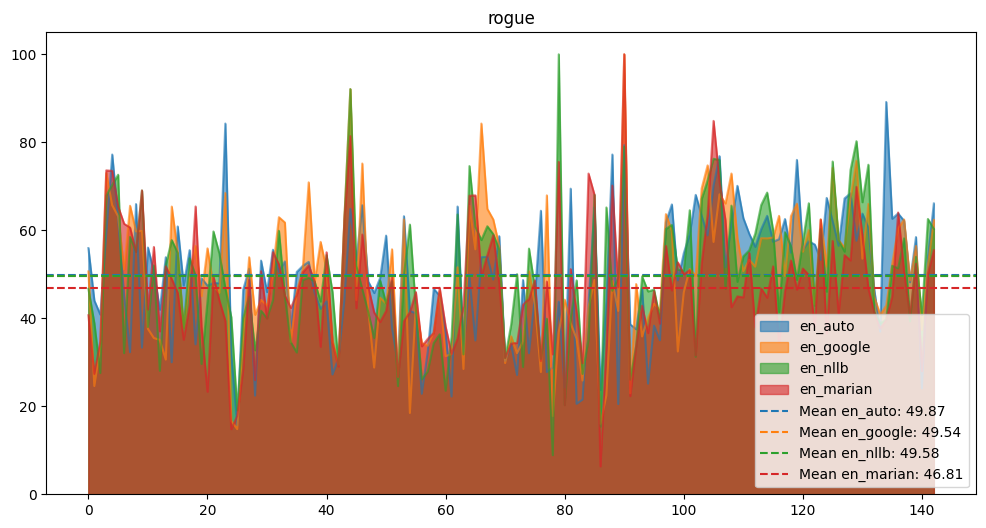

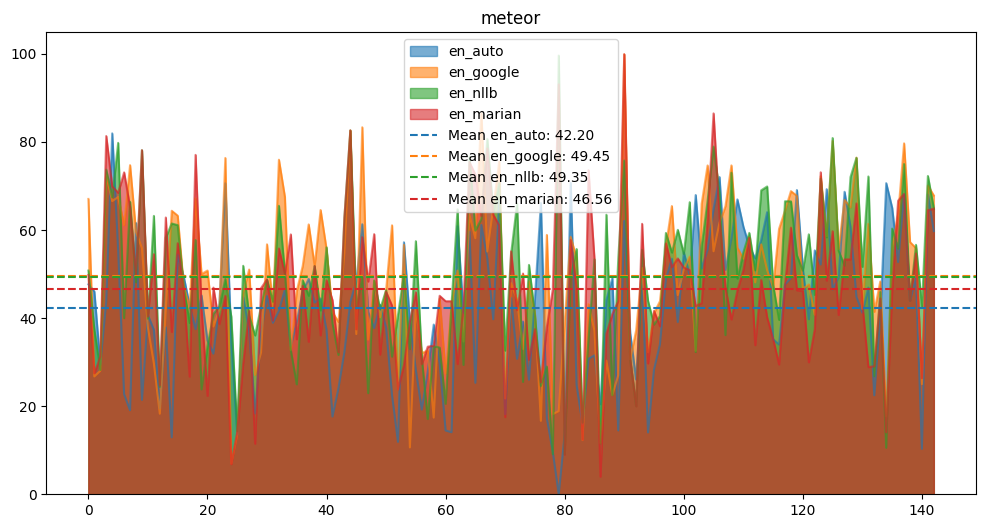

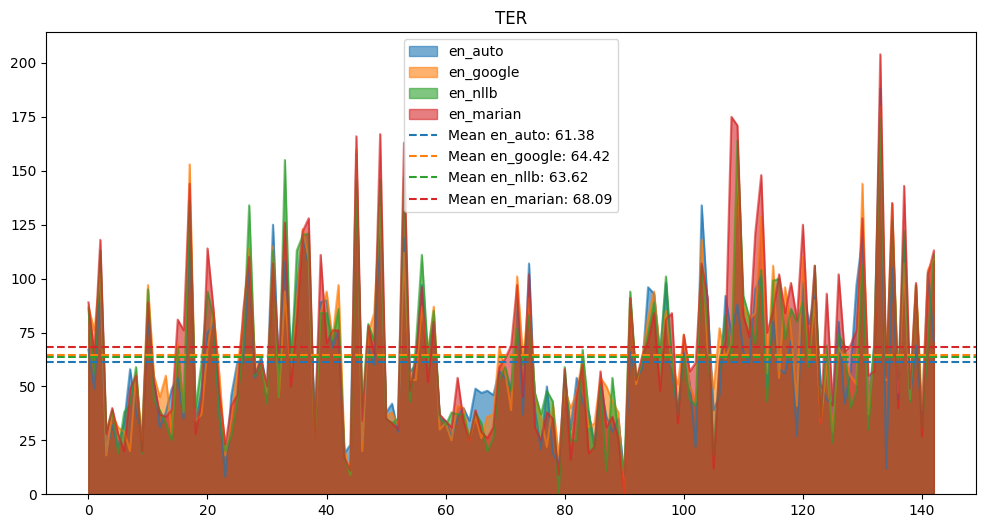

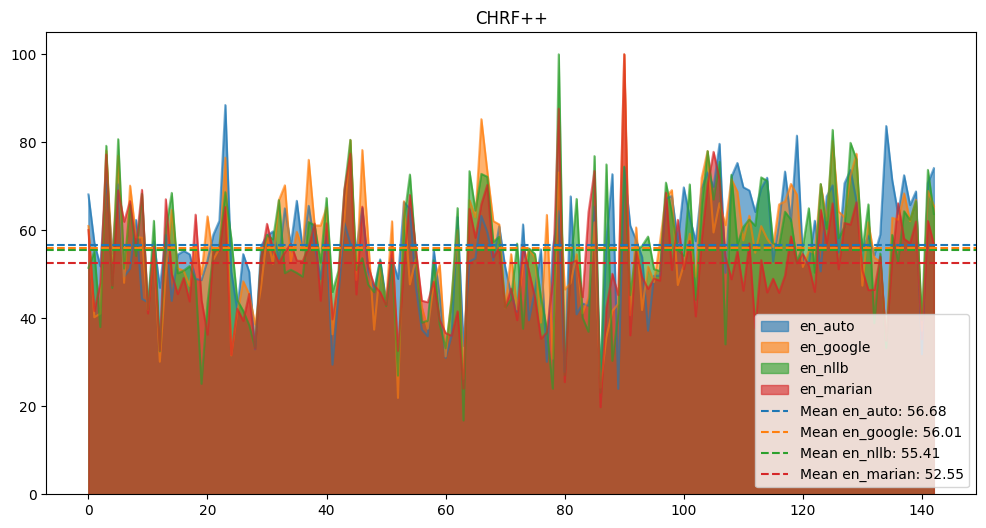

In [19]:
for name, func in METRICS.items():
  test_metric(func, name)

## Create DFs for further use

In [31]:
def col_metrics(col:str) -> pd.DataFrame:
  '''Return a dataframe if only values required.
     otherwise use cometrics_df to create a df with input and ref text'''
  scores = pd.DataFrame()
  for name, func in METRICS.items():
    scores[col+'_'+name] = df.apply(lambda row: func(row[col], row['en_expert']), axis=1)
  return scores


def colmetrics_df(col:str) -> pd.DataFrame:
  '''Return and dataframe with metrics, original input and reference expert translation'''
  metric = col_metrics(col)
  newdf = df[['ru', 'en_expert']].copy()
  for col in metric.columns:
    newdf[col]=metric[col]
  return newdf


def dfs_with_metrics() -> Dict:
  '''Return a list of all dataframes with metrics, original input and ref translation'''
  return {col:colmetrics_df(col) for col in df.columns[2:]}


def just_metrics() -> pd.DataFrame:
  '''Return a dataframe that has only metrics without text'''
  new_df = pd.DataFrame()
  for dataframe in dfs_with_metrics().values():
    for col in dataframe.columns:
      if col not in df.columns:
        new_df[col] = dataframe[col]
  return new_df


def save_df(name, dataframe, download=True) -> None:
  '''Save one dataframe as .tsv
    (optional) downloads it'''
  filename = name + '_metrics.tsv'
  dataframe.to_csv(filename, sep='\t')
  if download:
    files.download(filename)


def save_all_dfs(download=True) -> None:
  for name, dataframe in dfs_with_metrics().items():
    save_df(name, dataframe, download)

#### Save dataframes

In [33]:
save_df('numbers', just_metrics()) #just values with all columns

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [23]:
save_all_dfs()  # metrics for different models

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>